# Computer Vision: Building a model with skip connections, assessing its certainty and wrapping it all in a class

In this notebook I am going to build a model, that will be trained on a CIFAR10 dataset. The model will be built by the use of Keras functional API. The infrastructure of the model will have skip connections similarly to ResNet models.

I will try to measure the certainty of the model as well. That information will give us the information, if we really can trust its results.

All of above will be wrapped in a class - a subclass of Model class from Keras.

In [1]:
from tensorflow.keras.datasets import cifar10 as dataset
(X_train, y_train), (X_test, y_test) = dataset.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


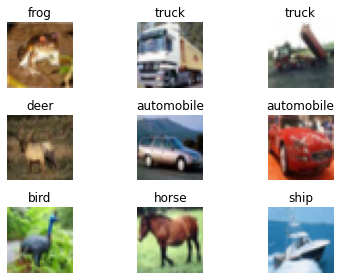

In [3]:
import matplotlib.pyplot as plt
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
  plt.title(labels[y_train[i]])
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [10]:
print("min: {}, max:{}".format(np.min(X_train), np.max(X_train)))
X_train = X_train.astype('float32') / np.max(X_train)
X_test = X_test.astype('float32') / np.max(X_test)
print("min: {}, max:{}".format(np.min(X_train), np.max(X_train)))

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print(y_train[0])
print(Y_train[0])

min: 0.0, max:1.0
min: 0.0, max:1.0
6
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [11]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input
from tensorflow.keras.layers import add, Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

In [12]:
class My_model(Model):
  def __init__(self):
    super(My_model, self).__init__()
    self.conv1 = Conv2D(64, kernel_size=(3,3),  strides=(1,1), activation='relu')
    self.bn1 = BatchNormalization()
    self.max1 = MaxPooling2D(pool_size=(3,3), strides = (1,1))
    self.drop1 = Dropout(0.2)
    
    self.conv2 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
    self.bn2 = BatchNormalization()
    self.conv3 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
    self.bn3 = BatchNormalization()
    self.max2 = MaxPooling2D(pool_size=(2,2))
    self.drop2 = Dropout(0.2)
    
    self.conv4 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
    self.bn4 = BatchNormalization()
    self.conv5 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
    self.bn5 = BatchNormalization()
    self.max3 = MaxPooling2D(pool_size=(2,2))
    self.drop3 = Dropout(0.2)
  
    self.conv6 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
    self.bn6 = BatchNormalization()
    self.conv7 = Conv2D(128, kernel_size=(3,3), activation='relu', padding='same')
    self.bn7 = BatchNormalization()
    self.max4 = MaxPooling2D(pool_size=(2,2))
    self.drop4 = Dropout(0.2)
    
    self.flatten = Flatten()
    self.dense = Dense(128, activation='relu')
    self.softmax = Dense(10, activation='softmax')

  def call(self, inputs):
    #inputs = keras.Input(shape=(32, 32, 3))
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.max1(x)
    block_1_output = self.drop1(x)
    
    x = self.conv2(block_1_output)
    x = self.bn2(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = self.max2(x)
    block_2_output = self.drop2(x)
    
    x = self.conv4(block_2_output)
    x = self.bn4(x)
    #first skip connection
    block_3a_output = add([x, block_2_output])
    x = self.conv5(block_3a_output)
    x = self.bn5(x)
    x = self.max3(x)
    block_3_output = self.drop3(x)

    x = self.conv6(block_3_output)
    x = self.bn6(x)
    #second skip connection
    block_4a_output = add([x, block_3_output])
    x = self.conv7(block_4a_output)
    x = self.bn7(x)
    x = self.max4(x)
    x = self.drop4(x)
    
    x = self.flatten(x)
    x = self.dense(x)
    x = self.softmax(x)
    return x

  def predict_classes(self, input_array: np.ndarray):
    # Given a batch of examples return a batch of predicted classes.
    pred_classes = np.argmax(self.predict(input_array),axis=1)
    return pred_classes

  def certainty(self, input_array: np.ndarray) -> np.ndarray:
    # Given a batch of examples return a batch of certainty levels.
    scores = np.max(self.predict(input_array), axis = 1)
    return scores.mean()

  def hist_good_pred(self, X, y ):
    good_preds = []
    pred_scores = np.max(self.predict(X), axis = 1)
    pred_classes = np.argmax(self.predict(X), axis = 1)
    for i in range(len(X)):
      if pred_classes[i] == y[i]:
        good_preds.append(pred_scores[i])
    fig = plt.figure()
    plt.hist(good_preds, bins=10)
    return fig
    
  def hist_bad_pred(self, X, y ):
    bad_preds = []
    pred_scores = np.max(self.predict(X), axis = 1)
    pred_classes = np.argmax(self.predict(X), axis = 1)
    for i in range(len(X)):
      if pred_classes[i] != y[i]:
        bad_preds.append(pred_scores[i])
    fig = plt.figure()
    plt.hist(bad_preds, bins=10)
    return fig

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 30, 30, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 28, 28, 64)   0           ['batch_normalization[0][0]']

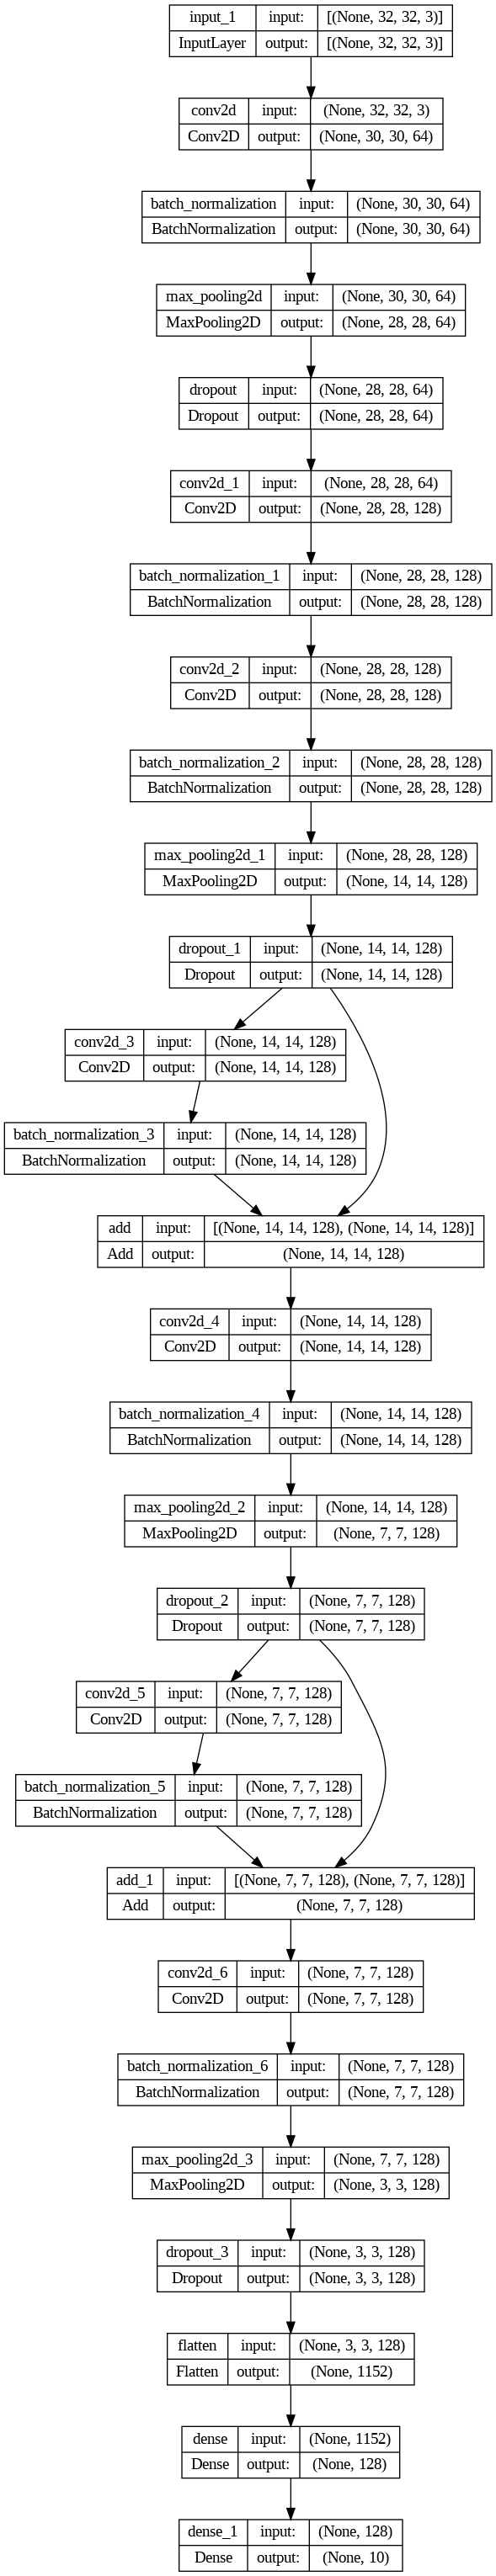

In [13]:
my_model = My_model()  
my_model.build(input_shape = (1,32,32,3))

# Class MyModel(Model) does not have any def build_graph function, therefore below lines are needed to visualize the model infrastructure
inputs = Input(shape=(32,32,3))
model = Model(inputs=[inputs],outputs=my_model.call(inputs))

# The model summary
model.summary(expand_nested = True)

# Plotting the visualization of the model.
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, expand_nested=True)

In [14]:
es = EarlyStopping(patience=5, monitor="val_loss")

In [15]:
my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
my_model.fit(X_train, Y_train, epochs=100, batch_size=256, validation_split=0.1, callbacks=[es])

Epoch 1/100
176/176 [==============================] - 30s 116ms/step - loss: 1.5051 - accuracy: 0.4659 - val_loss: 3.2066 - val_accuracy: 0.1272
Epoch 2/100
176/176 [==============================] - 17s 98ms/step - loss: 1.0023 - accuracy: 0.6452 - val_loss: 2.7614 - val_accuracy: 0.2742
Epoch 3/100
176/176 [==============================] - 18s 100ms/step - loss: 0.7862 - accuracy: 0.7234 - val_loss: 1.0051 - val_accuracy: 0.6464
Epoch 4/100
176/176 [==============================] - 18s 100ms/step - loss: 0.6741 - accuracy: 0.7630 - val_loss: 0.9301 - val_accuracy: 0.6988
Epoch 5/100
176/176 [==============================] - 18s 103ms/step - loss: 0.5797 - accuracy: 0.7972 - val_loss: 0.7865 - val_accuracy: 0.7394
Epoch 6/100
176/176 [==============================] - 18s 102ms/step - loss: 0.5189 - accuracy: 0.8190 - val_loss: 0.7816 - val_accuracy: 0.7384
Epoch 7/100
176/176 [==============================] - 18s 102ms/step - loss: 0.4641 - accuracy: 0.8371 - val_loss: 1.5433 - 

In [16]:
my_model.evaluate(X_train, Y_train)
my_model.evaluate(X_test, Y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.7206 - accuracy: 0.8126


[0.7205965518951416, 0.8126000165939331]

In [17]:
#Returning a batch of predicted classes 
my_model.predict_classes(X_test)

313/313 [==============================] - 2s 5ms/step


array([3, 8, 8, ..., 5, 1, 7])

In [18]:
# Returning a batch of certainty levels.
my_model.certainty(X_test)

313/313 [==============================] - 1s 5ms/step


0.90976936

313/313 [==============================] - 1s 4ms/step


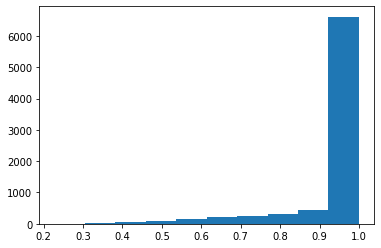

In [19]:
# histogram of certainty metric for properly classified examples
my_model.hist_good_pred(X_test,y_test)
plt.show()

313/313 [==============================] - 1s 4ms/step


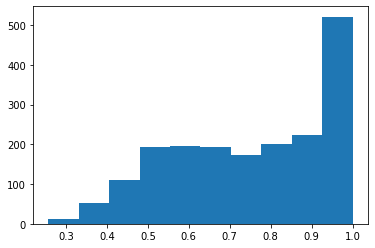

In [20]:
# histogram of certainty metric for missclassified examples
my_model.hist_bad_pred(X_test,y_test)
plt.show()

Above histograms show, that model can be trusted when it comes to proper predictions. In that case the output for predicted class was above 0,9 in the vast majority of cases.

On the other hand, in case of misclassifications the results were not so obvious.

Based on that, we can say that model "was sure" of its good predictions, but in case of missclassifications the results were not unambiguous. These results prove, that the model can be trusted.

## Conclusion

In this notebook I built a model with skip connections, that achieved quite good results on CIFAR10 dataset (0,81 on test data).

The model was wrapped in a class. Additionally, I defined methods that return predicted classes or certainty metrics which indicate if the prediction cas be trusted. I plotted the histograms of these metrics for both properly classified and misclassified examples. The histograms show a great difference between outputs of proper and bad classifications.